# Exploring the Sensitivity of Photosynthesis and Stomatal Resistance Parameters in a Land Surface Model

__Jennifer Jefferson__, Colorado School of Mines, <jejeffer@mines.edu>

__Reed Maxwell__, Colorado School of Mines, <rmaxwell@mines.edu>

__Paul Constantine__, Colorado School of Mines, <pconstan@mines.edu>

__Ryan Howard__, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces methodology and results on transpiration and stomatal resistance in the ParFlow Common Land Model (PF-CLM), presented in [1].

### Introduction

Vegetation on the land surface takes water from the subsurface and releases it into the atmosphere in a process called _transpiration_, which can be a significant factor in latent energy fluxes between the ground and atmosphere. The plant physiology that determines transpiration in land surface models is put into the _stomatal resistance_ term, of which several parameterizations exist. For example, the Ball-Berry parameterization depends on photosynthesis, carboxylation, and export of reaction products, which are explicity characterized by 20 parameters; we are interested in determining the sensitivity of model output to these parameters.

To perform our sensitivity analysis, we use the _active subspace_ method, which gives us information about the relative importance of paramters and a low-dimensional model that aids in visualizing the relationship between inputs and the model output. The model we use is the ParFlow Common Land Model (PF-CLM) and the quantities of interest (model outputs) we examine are transpiration, stomatal resistance in sunlight, and stomatal resistance in shade. We use one year of atmospheric forcing data from the Tonzi Ranch in California to examine the time-dependence of parameter sensitivities.

### Active Subspaces

Consider a model's output, $f$, as a function of normalized input parameters, $\mathbf x$: $f = f(\mathbf x)$. The active subspace method is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T\rho(\mathbf x)\ d\mathbf x = \mathbf W\Lambda\mathbf W^T,
$$

where $\rho$ is a probability density on $\mathbf x$ and $\mathbf W\Lambda\mathbf W^T$ is the eigendecomposition of $\mathbf C$ with the eigenvalues in descending order. The eigenvalues quantify how much $f$ changes, on average, in the directions defined by their corresponding eigenvector; if the first $n$ eigenvalues are much larger than the rest, then $f$ might be well characterized in the subspace of the parameter space defined by the span of the first $n$ eigenvectors.

Approximating $\mathbf C$ requires access to the gradient of $f$ with respect to $\mathbf x$; we don't have gradients for the PF-CLM, so we use the following algorithm to identify the _sigle_ most important direction in the parameter space:

1. Draw $\{\mathbf x_j\}_{j=1}^M$ from $\rho$ and compute $f_j = f(\mathbf x_j)\ \forall j$.
2. Fit the linear approximation $f_j\approx a + \mathbf a^T\mathbf x_j$.
3. The most important direction in the input space is $\mathbf w = \frac{\mathbf a}{||\mathbf a||}$.

Larger-magnitude components of $\mathbf w$ indicate relative sensitivity to the corresponding parameter. We can create a _summary plot_: a plot of data values, $f_j$, versus active variable values, $\mathbf w^T\mathbf x_j$; if a tight univariate trend exists, we can reasonably characterize model output as a function of the active variable.

### The Hydrologic Model

The ParFlow Common Land Model is a set of algebraic and differential equations governing energy and mass fluxes, whose solution we can use to calculate our quantities of interest. The parameters we study and their distributions are described in the table below.

Variable | Name | Distribution (U(min, max))
:--------|:----:|:-----------------:
Maximum Carboxylation Rate | vcmx25 | U(20, 65)
q10 for vcmx25 | avcmx | U(2.2, 2.6)
Deactivation Energy Constant | hv | U(218000, 242000)
Entropy Constant | sv | U(640, 730)
CO2 Michaelis-Menten Constant | kc25 | U(25, 50)
q10 for kc25 | akc | U(1.9, 2.3)
O2 Michaelis-Menten Constant | ko25 | U(30000, 45000)
q10 for ko25 | ako | U(1.1, 1.3)
Maximum Oxygenation/Carboxylation Ratio | ocr | U(0.18, 0.77)
ci Multiplier | wj1 | U(1, 4.5)
cp Multiplier | wj2 | U(2, 10.5)
Photon Energy Content | ecp | U(3.3, 5.8)
Quantum Efficiency | qe25 | U(.04, .08)
Multiplier in we | we1 | U(0.45, 0.55)
CO2 Partial Pressure | ppcd | U(355, 400)
Boundary Diffusivity Ratio | drb | U(1.3, 1.4)
Stomata Diffusivity Ratio | drs | U(1.6, 1.7)
Minimum Leaf Conductance | bp | U(1000, 10000)
Conductance-Photosynthesis Slope | mp | U(4, 12)
Maximum Stomatal Resistance | rsmax0 | U(10000, 40000)

Our dataset contains 300 input/output pairs with inputs drawn from the distributions above; we apply the algorithm from the previous section with these pairs to construct active subspaces for each quantity of interest for both average monthly and average hourly values.

### References:

[[1]][R1] J. Jefferson. _Exploring sensitivities of latent heat parameterizations using a coupled, integrated hydrologic model_. Ph.D. Thesis, Colorado School of Mines, 2016

[[2]][R2] P.G. Constantine, E. Dow, and Q. Wang. _Active subspaces in theory and practice: applications to kriging surfaces_. SIAM J. Sci. Comput., 36(4), A1500–A1524, 2014

[R1]: http://hdl.handle.net/11124/170080
[R2]: http://dx.doi.org/10.1137/130916138

### Acknowledgments

This material is based upon work supported by the U.S. Department of Energy Office of Science, Office of Advanced Scientific Computing Research, Applied Mathematics program under Award Number DE-SC-0011077.

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import active_subspaces as ac

First we read in parameter realizations, normalize the parameters each to the interval $[-1, 1]$ (with bounds also read from a file), and read in model output (transpiration, shaded stomatal resistance, and sunlit stomatal resistance) averaged by month and by hour.

In [2]:
#Read the parameter realizations
X = pn.DataFrame.from_csv('stomata_realization_inputs.txt', sep=' ', index_col=None)
in_labels = X.keys()
X = X.as_matrix()

#Read the parameter bounds
bounds = pn.DataFrame.from_csv('param_ranges.txt', sep=' ', index_col=None).as_matrix()
lb = bounds[:,0]; ub = bounds[:,1]

#Normalize the inputs to the interval [-1, 1]
XX = ac.utils.misc.BoundedNormalizer(lb, ub).normalize(X)

#Read monthly-averaged model output
res_shade_monthly = pn.DataFrame.from_csv('Tonzi_Stomata_SC.mo_avg_rssha.txt', sep=' ',
                                         index_col=None).as_matrix()
res_sun_monthly = pn.DataFrame.from_csv('Tonzi_Stomata_SC.mo_avg_rssun.txt', sep=' ',
                                         index_col=None).as_matrix()
trans_monthly = pn.DataFrame.from_csv('Tonzi_Stomata_SC.mo_avg_tran_veg.txt', sep=' ',
                                         index_col=None).as_matrix()
#Labels for the months
month_labels = ["September", "October", "November", "December", "January", "February",
                "March", "April", "May", "June", "July", "August"]

#Labels for the hours
hour_labels = ["GMT_12", "GMT_13", "GMT_14", "GMT_15", "GMT_16", "GMT_17",
               "GMT_18", "GMT_19", "GMT_20", "GMT_21", "GMT_22", "GMT_23", "GMT_0", "GMT_1"]
#Read hourly-averaged model output
res_shade_hourly = pn.DataFrame.from_csv('Tonzi_Stomata_SC.JJA_hr_avg_rssha.txt', sep=' ',
                                         index_col=None)[hour_labels].as_matrix()
res_sun_hourly = pn.DataFrame.from_csv('Tonzi_Stomata_SC.JJA_hr_avg_rssun.txt', sep=' ',
                                         index_col=None)[hour_labels].as_matrix()
trans_hourly = pn.DataFrame.from_csv('Tonzi_Stomata_SC.JJA_hr_avg_tran_veg.txt', sep=' ',
                                         index_col=None)[hour_labels].as_matrix()

Now for the 6 cases of either monthly- or hourly-averaged data and each of the 3 outputs, we plot $\mathbf w$, the vector of weights defining the active subspaces, and summary plots showing model output versus the active variable, $\mathbf w^T\mathbf x$. We start with the 3 outputs and monthly data.

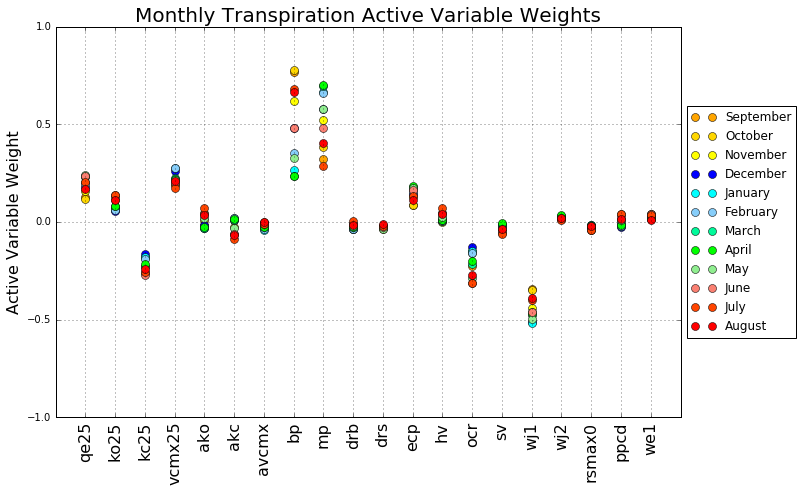

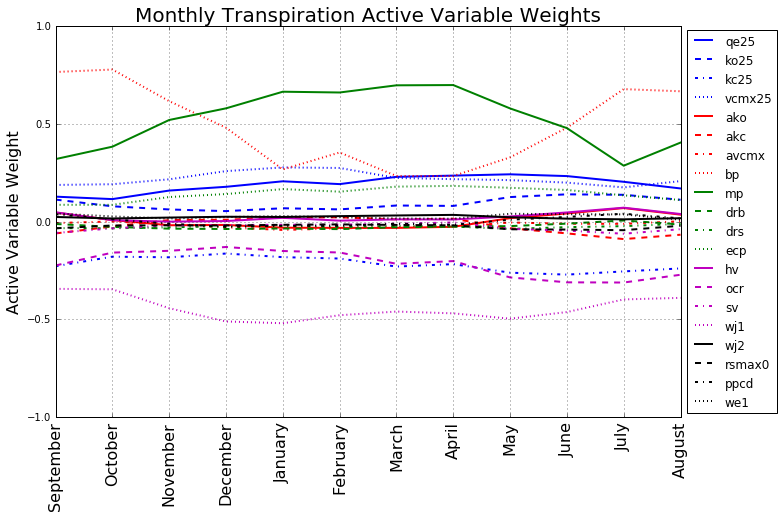

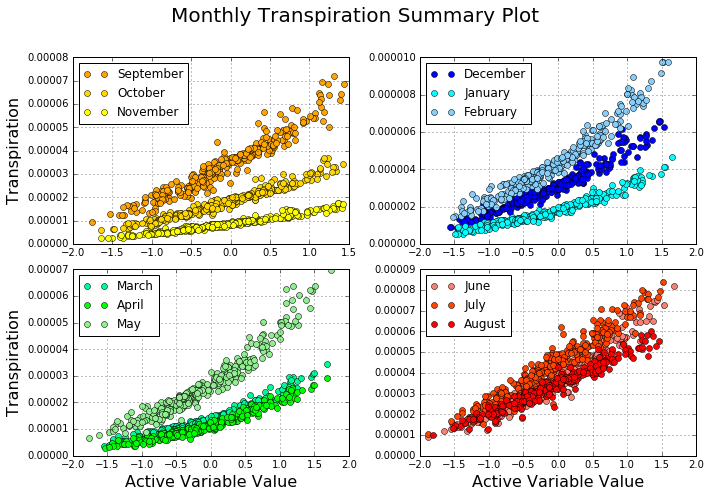

In [3]:
#Make plots for monthly-averaged transpiration

#Instantiate a subspace object
ss = ac.subspaces.Subspaces()

#Colors for the markers on the plots
colors = ['orange', 'gold', 'yellow', 'blue', 'cyan', 'lightskyblue', 'mediumspringgreen', 
          'lime', 'lightgreen', 'salmon', 'orangered', 'red']

plt.figure(figsize=(14, 7))
for i in range(trans_monthly.shape[1]):
    #Compute the active subspace
    ss.compute(X=XX, f=trans_monthly[:,i][:,None], sstype='OLS')
    #Plot the weights on the input variables defining the active subspaces
    plt.plot(range(1, 21), ss.W1, linewidth=0, marker='o', color=colors[i],
             markersize=8, label=month_labels[i])
plt.xticks(range(1, 21), in_labels, rotation='vertical', fontsize=16)
plt.ylim([-1, 1]); plt.xlim([0, 21]); plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Monthly Transpiration Active Variable Weights', fontsize=20)

#Plot active variable weight as a function of time
Colors = ['b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'g', 'm', 'm', 'm',
          'm', 'k', 'k', 'k', 'k']
styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--',
          '-.', ':', '-', '--', '-.', ':']
trans_monthly_weights = np.empty((12, 20))
for i in range(12):
    ss.compute(X=XX, f=trans_monthly[:,i][:,None], sstype='OLS')
    trans_monthly_weights[i,:] = ss.W1.squeeze()
plt.figure(figsize=(14, 7))
for i in range(20):
    plt.plot(range(0, 12), trans_monthly_weights[:,i], color=Colors[i], linestyle=styles[i],
             linewidth=2, label=in_labels[i])
plt.xticks(range(0, 12), month_labels, rotation='vertical', fontsize=16)
plt.xlim((0, 11))
plt.ylim([-1, 1])
plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Monthly Transpiration Active Variable Weights', fontsize=20)

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle('Monthly Transpiration Summary Plot', fontsize=20)
for j in range(4):
    plt.subplot(2, 2, j+1)
    for k in range(3):
        i = 3*j + k
        ss.compute(X=XX, f=trans_monthly[:,i][:,None], sstype='OLS')
        #Plot model output vs the active variable
        plt.plot(XX.dot(ss.W1), trans_monthly[:,i], linewidth=0, marker='o', color=colors[i],
                 markersize=6, label=month_labels[i])
    plt.grid(True)
    if j in (0, 2): plt.ylabel('Transpiration', fontsize=16)
    if j in (2, 3): plt.xlabel('Active Variable Value', fontsize=16)
    plt.legend(loc='upper left')
fig.tight_layout()
fig.subplots_adjust(top=0.88)

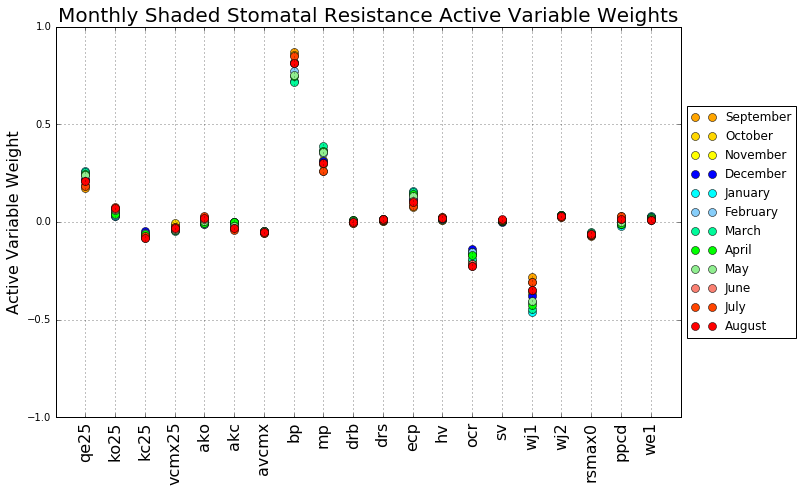

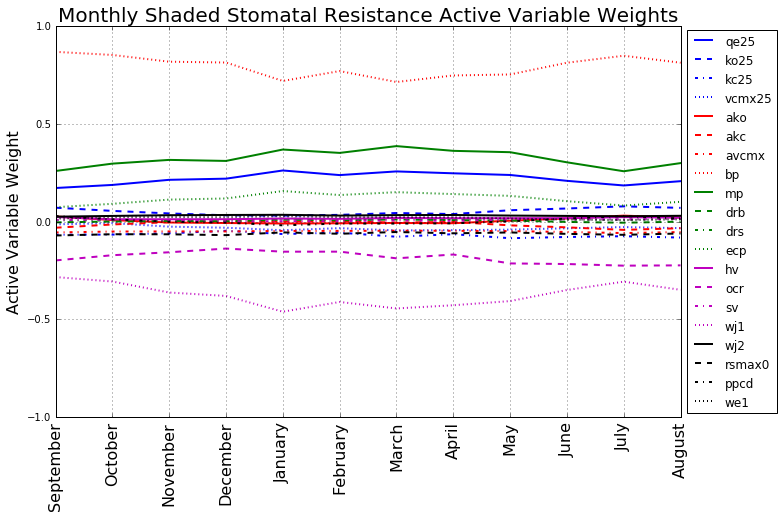

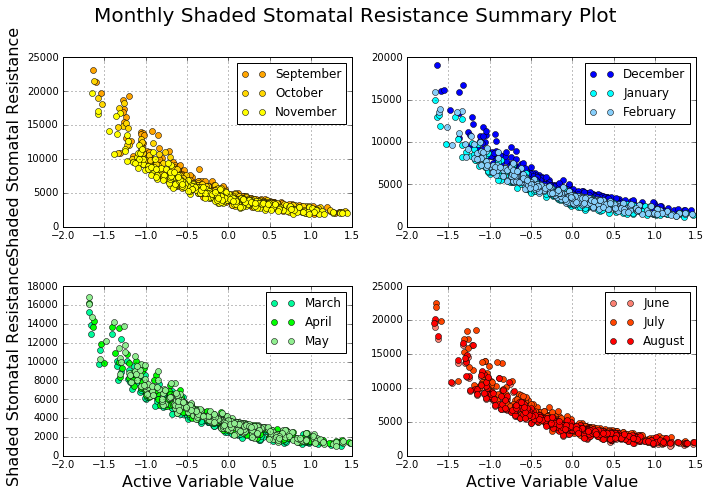

In [4]:
#Make plots for monthly-averaged shaded stomatal resistance

plt.figure(figsize=(14, 7))
for i in range(res_shade_monthly.shape[1]):
    ss.compute(X=XX, f=res_shade_monthly[:,i][:,None], sstype='OLS')
    plt.plot(range(1, 21), ss.W1, linewidth=0, marker='o', color=colors[i],
             markersize=8, label=month_labels[i])
plt.xticks(range(1, 21), in_labels, rotation='vertical', fontsize=16)
plt.ylim([-1, 1]); plt.xlim([0, 21]); plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Monthly Shaded Stomatal Resistance Active Variable Weights', fontsize=20)

res_shade_monthly_weights = np.empty((12, 20))
for i in range(12):
    ss.compute(X=XX, f=res_shade_monthly[:,i][:,None], sstype='OLS')
    res_shade_monthly_weights[i,:] = ss.W1.squeeze()
plt.figure(figsize=(14, 7))
for i in range(20):
    plt.plot(range(0, 12), res_shade_monthly_weights[:,i], color=Colors[i], linestyle=styles[i],
             linewidth=2, label=in_labels[i])
plt.xticks(range(0, 12), month_labels, rotation='vertical', fontsize=16)
plt.xlim((0, 11))
plt.ylim([-1, 1])
plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Monthly Shaded Stomatal Resistance Active Variable Weights', fontsize=20)

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle('Monthly Shaded Stomatal Resistance Summary Plot', fontsize=20)
for j in range(4):
    plt.subplot(2, 2, j+1)
    for k in range(3):
        i = 3*j + k
        ss.compute(X=XX, f=res_shade_monthly[:,i][:,None], sstype='OLS')
        plt.plot(XX.dot(ss.W1), res_shade_monthly[:,i], linewidth=0, marker='o', color=colors[i],
                 markersize=6, label=month_labels[i])
    plt.grid(True)
    if j in (0, 2): plt.ylabel('Shaded Stomatal Resistance', fontsize=16)
    if j in (2, 3): plt.xlabel('Active Variable Value', fontsize=16)
    plt.legend(loc='upper right')
fig.tight_layout()
fig.subplots_adjust(top=0.88)    

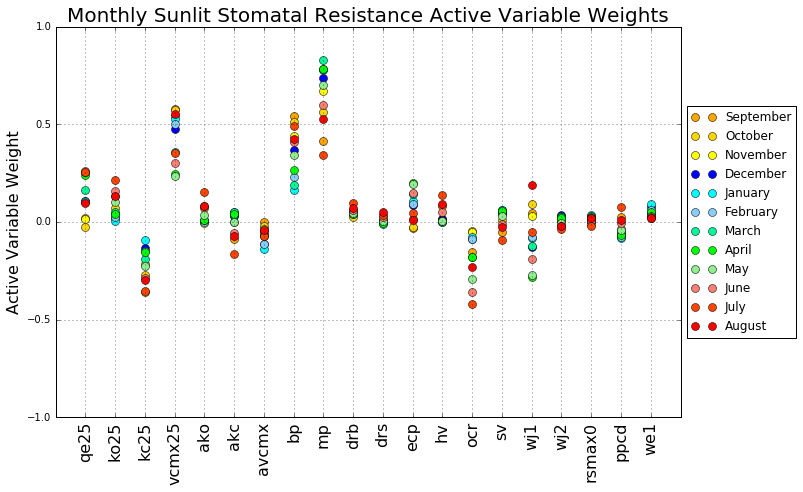

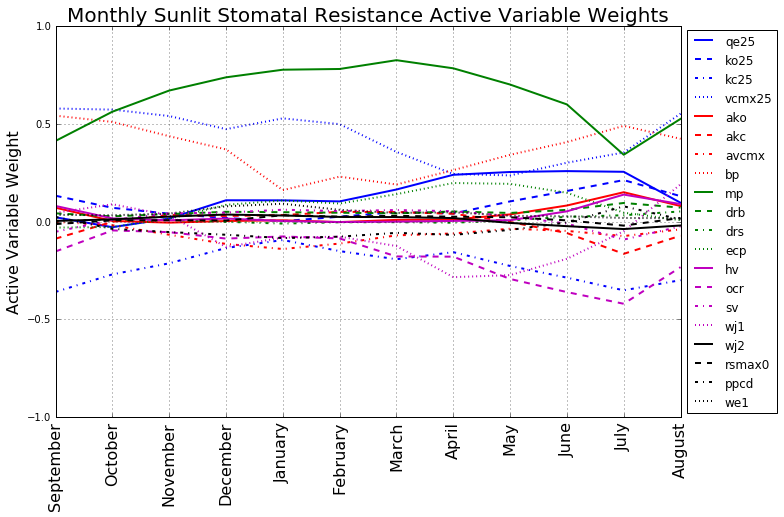

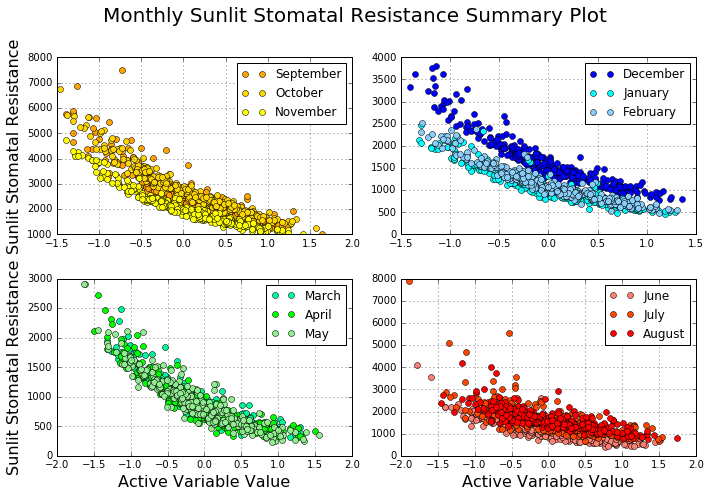

In [5]:
#Make plots for monthly-averaged sunlit stomatal resistance

plt.figure(figsize=(14, 7))
for i in range(res_sun_monthly.shape[1]):
    ss.compute(X=XX, f=res_sun_monthly[:,i][:,None], sstype='OLS')
    if month_labels[i]=='October': ss.W1 *= -1.0
    plt.plot(range(1, 21), ss.W1, linewidth=0, marker='o', color=colors[i],
             markersize=8, label=month_labels[i])
plt.xticks(range(1, 21), in_labels, rotation='vertical', fontsize=16)
plt.ylim([-1, 1]); plt.xlim([0, 21]); plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Monthly Sunlit Stomatal Resistance Active Variable Weights', fontsize=20)

res_sun_monthly_weights = np.empty((12, 20))
for i in range(12):
    ss.compute(X=XX, f=res_sun_monthly[:,i][:,None], sstype='OLS')
    if month_labels[i]=='October': ss.W1 *= -1.0
    res_sun_monthly_weights[i,:] = ss.W1.squeeze()
plt.figure(figsize=(14, 7))
for i in range(20):
    plt.plot(range(0, 12), res_sun_monthly_weights[:,i], color=Colors[i], linestyle=styles[i],
             linewidth=2, label=in_labels[i])
plt.xticks(range(0, 12), month_labels, rotation='vertical', fontsize=16)
plt.xlim((0, 11))
plt.ylim([-1, 1])
plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Monthly Sunlit Stomatal Resistance Active Variable Weights', fontsize=20)

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle('Monthly Sunlit Stomatal Resistance Summary Plot', fontsize=20)
for j in range(4):
    plt.subplot(2, 2, j+1)
    for k in range(3):
        i = 3*j + k
        ss.compute(X=XX, f=res_sun_monthly[:,i][:,None], sstype='OLS')
        if month_labels[i]=='October': ss.W1 *= -1.0
        plt.plot(XX.dot(ss.W1), res_sun_monthly[:,i], linewidth=0, marker='o', color=colors[i],
                 markersize=6, label=month_labels[i])
    plt.grid(True)
    if j in (0, 2): plt.ylabel('Sunlit Stomatal Resistance', fontsize=16)
    if j in (2, 3): plt.xlabel('Active Variable Value', fontsize=16)
    plt.legend(loc='upper right')    
fig.tight_layout()
fig.subplots_adjust(top=0.88)

We can see fairly tight univariate trends in each summary plot, indicating that we can use the subspaces we've discovered to reasonably analyze sensitivity to input parameters. For transpiration, we see that bp, mp, and wj1 are the most important parameters, some others (qe25, kc25, vcmx25, ocr) have small contributions, and the rest have weight close to 0, meaning they don't have much influence on output. bp, mp, and wj1 are also the most important for characterizing shaded stomatal resistance, with most of the parameters having almost no weight. In contrast to transpiration and shaded stomatal resistance, which have fairly constant weights month-to-month, sunlit stomatal resistance shows a lot of seasonal variation in active variable weights and many more parameters are important at at least one point in the year.

We'll now construct the same plots for hourly-averaged data (the summary plots show the log of stomatal resistance vs the active variable).

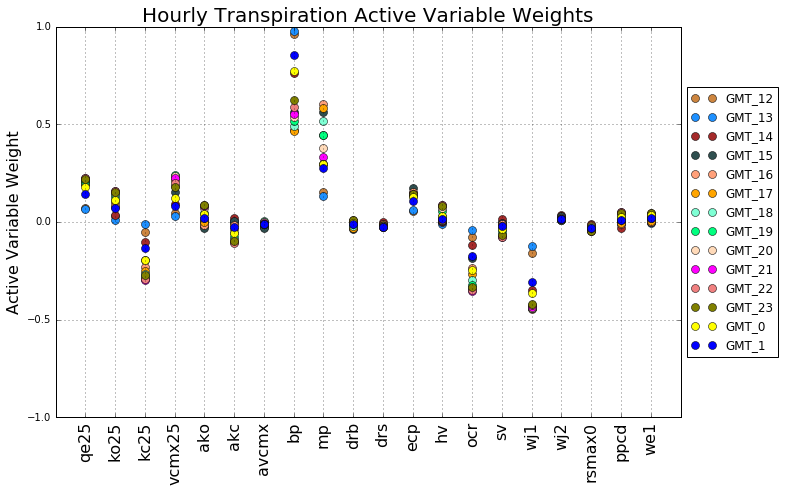

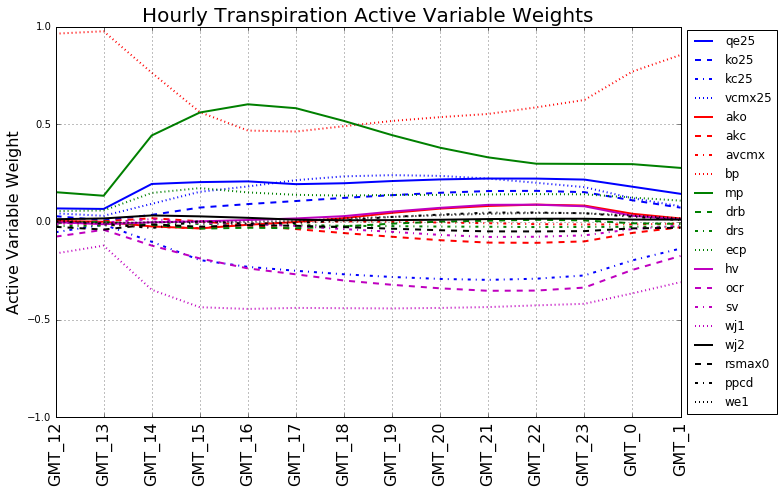

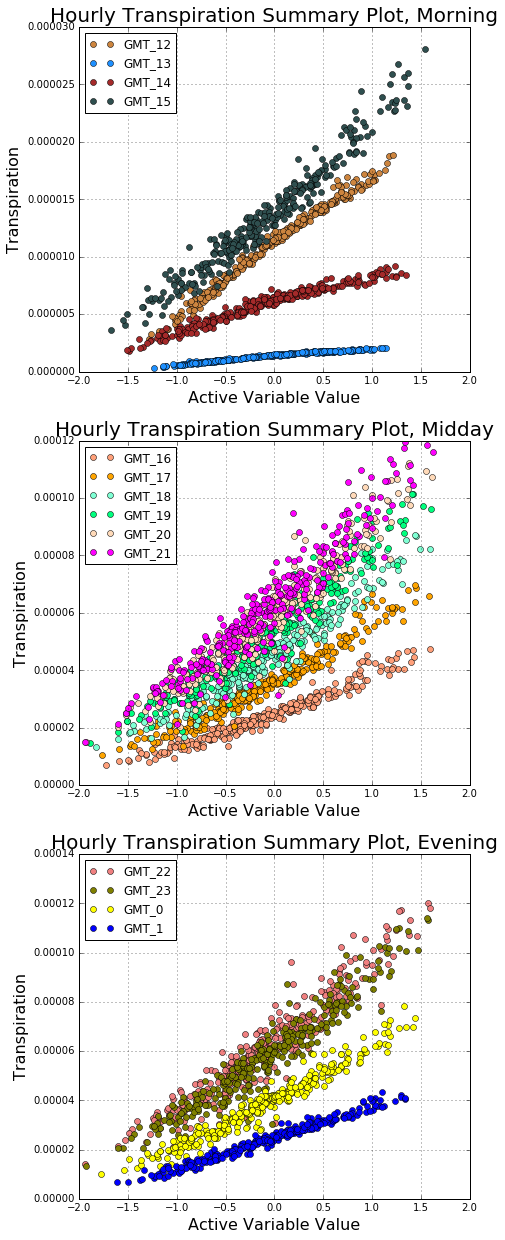

In [6]:
#Make plots for hourly-averaged transpiration

colors = ['peru', 'dodgerblue', 'brown', 'darkslategray', 'lightsalmon', 'orange',
          'aquamarine', 'springgreen', 'peachpuff', 'fuchsia', 'lightcoral', 'olive',
         'yellow', 'blue']
plt.figure(figsize=(14, 7))
for i in range(trans_hourly.shape[1]):
    ss.compute(X=XX, f=trans_hourly[:,i][:,None], sstype='OLS')
    plt.plot(range(1, 21), ss.W1, linewidth=0, marker='o', color=colors[i],
             markersize=8, label=hour_labels[i])
plt.xticks(range(1, 21), in_labels, rotation='vertical', fontsize=16)
plt.ylim([-1, 1]); plt.xlim([0, 21]); plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Hourly Transpiration Active Variable Weights', fontsize=20)

trans_hourly_weights = np.empty((14, 20))
for i in range(14):
    ss.compute(X=XX, f=trans_hourly[:,i][:,None], sstype='OLS')
    trans_hourly_weights[i,:] = ss.W1.squeeze()    
plt.figure(figsize=(14,7))
for i in range(20):
    plt.plot(range(0, 14), trans_hourly_weights[:,i], color=Colors[i], linestyle=styles[i],
             linewidth=2, label=in_labels[i])
plt.xticks(range(0, 14), hour_labels, rotation='vertical', fontsize=16)
plt.xlim((0, 13))
plt.ylim([-1, 1])
plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Hourly Transpiration Active Variable Weights', fontsize=20)


indices = [[0, 1, 2, 3], [4, 5, 6, 7, 8, 9], [10, 11, 12, 13]]
times = ['Morning', 'Midday', 'Evening']
plt.subplots(3, 1, figsize=(7, 7*3))
for j in range(3):
    plt.subplot(3, 1, j+1)
    for k in range(len(indices[j])):
        i = indices[j][k]
        ss.compute(X=XX, f=trans_hourly[:,i][:,None], sstype='OLS')
        plt.plot(XX.dot(ss.W1), trans_hourly[:,i], linewidth=0, marker='o', color=colors[i],
                 markersize=6, label=hour_labels[i])
    plt.grid(True)
    plt.ylabel('Transpiration', fontsize=16)
    plt.xlabel('Active Variable Value', fontsize=16)
    plt.legend(loc='upper left')
    plt.title('Hourly Transpiration Summary Plot, {}'.format(times[j]), fontsize=20)

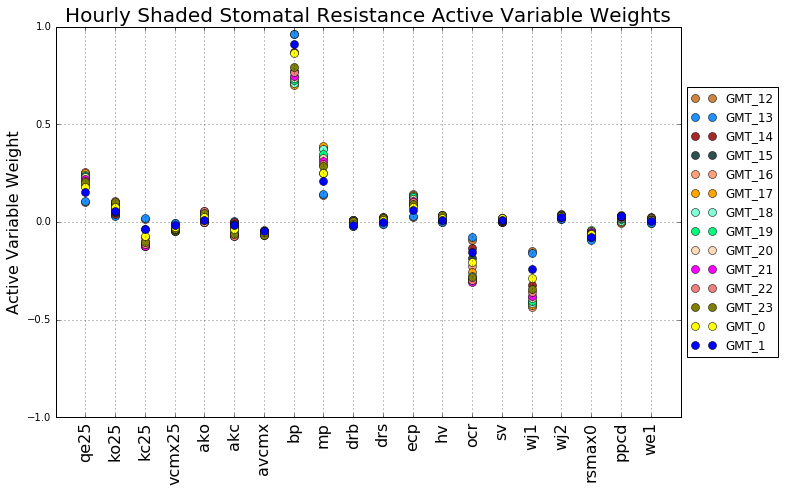

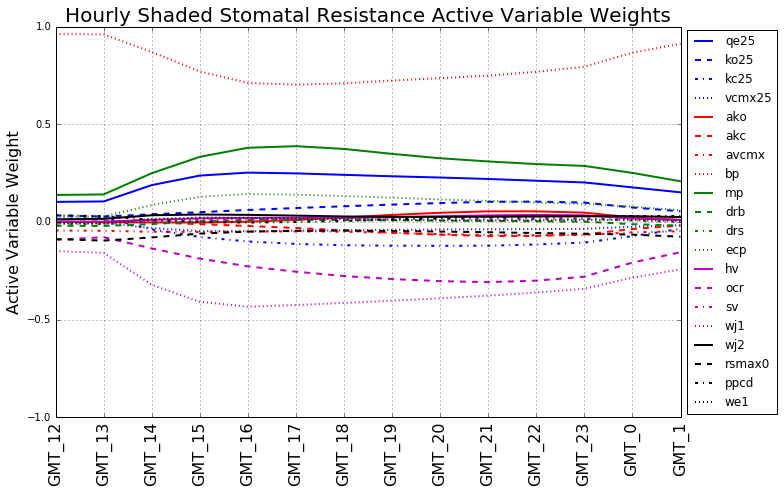

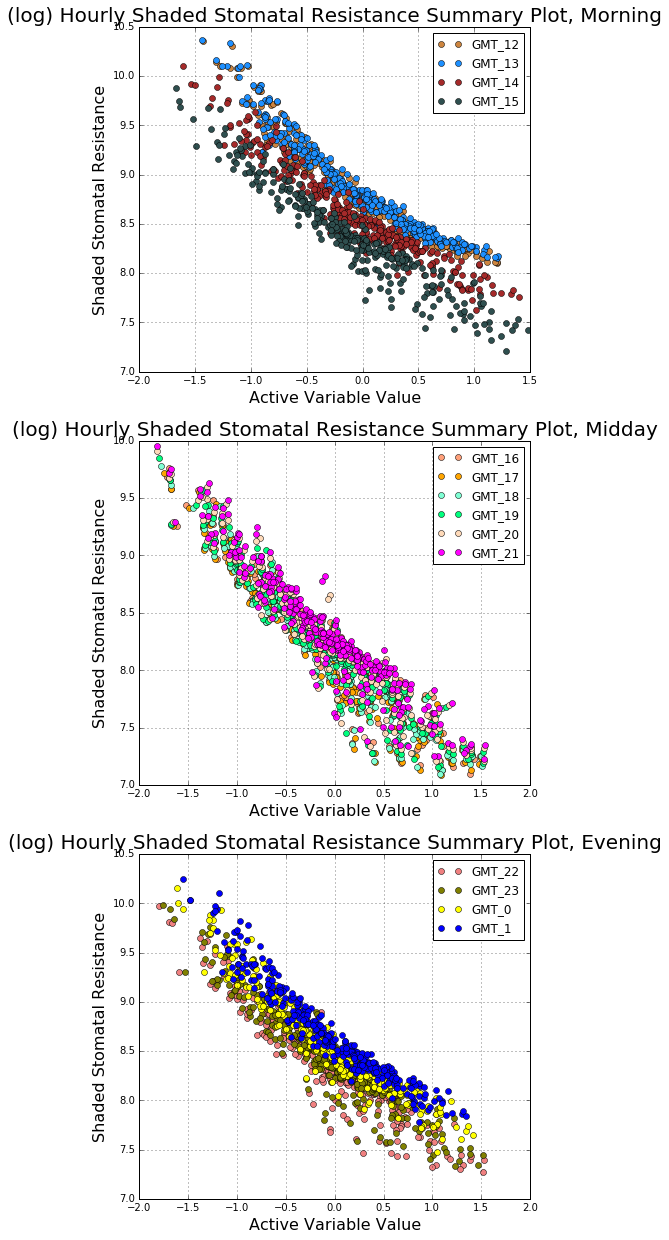

In [7]:
#Make plots for hourly-averaged shaded stomatal resistance

plt.figure(figsize=(14, 7))
for i in range(res_shade_hourly.shape[1]):
    ss.compute(X=XX, f=res_shade_hourly[:,i][:,None], sstype='OLS')
    plt.plot(range(1, 21), ss.W1, linewidth=0, marker='o', color=colors[i],
             markersize=8, label=hour_labels[i])
plt.xticks(range(1, 21), in_labels, rotation='vertical', fontsize=16)
plt.ylim([-1, 1]); plt.xlim([0, 21]); plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Hourly Shaded Stomatal Resistance Active Variable Weights', fontsize=20)

res_shade_hourly_weights = np.empty((14, 20))
for i in range(14):
    ss.compute(X=XX, f=res_shade_hourly[:,i][:,None], sstype='OLS')
    res_shade_hourly_weights[i,:] = ss.W1.squeeze()    
plt.figure(figsize=(14,7))
for i in range(20):
    plt.plot(range(0, 14), res_shade_hourly_weights[:,i], color=Colors[i], linestyle=styles[i],
             linewidth=2, label=in_labels[i])
plt.xticks(range(0, 14), hour_labels, rotation='vertical', fontsize=16)
plt.xlim((0, 13))
plt.ylim([-1, 1])
plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Hourly Shaded Stomatal Resistance Active Variable Weights', fontsize=20)

plt.subplots(3, 1, figsize=(7, 7*3))
for j in range(3):
    plt.subplot(3, 1, j+1)
    for k in range(len(indices[j])):
        i = indices[j][k]
        ss.compute(X=XX, f=res_shade_hourly[:,i][:,None], sstype='OLS')
        plt.plot(XX.dot(ss.W1), np.log(res_shade_hourly[:,i]), linewidth=0, marker='o',
                 color=colors[i], markersize=6, label=hour_labels[i])
    plt.grid(True)
    plt.ylabel('Shaded Stomatal Resistance', fontsize=16)
    plt.xlabel('Active Variable Value', fontsize=16)
    plt.legend(loc='upper right')
    plt.title('(log) Hourly Shaded Stomatal Resistance Summary Plot, {}'.format(times[j]), fontsize=20)

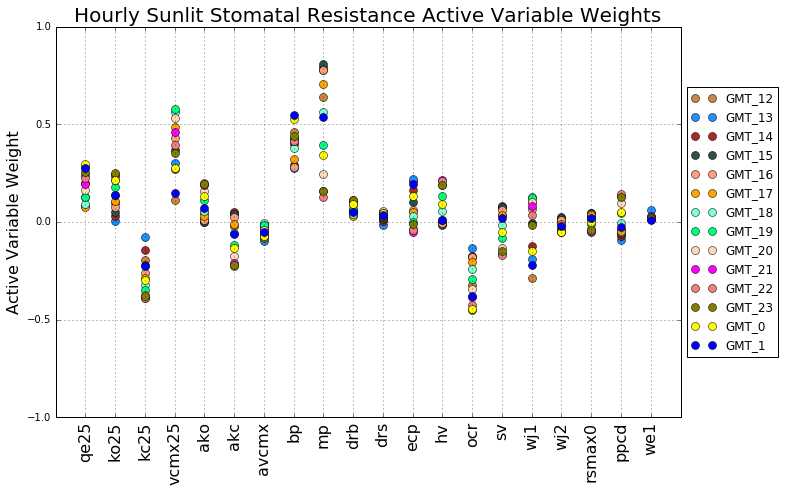

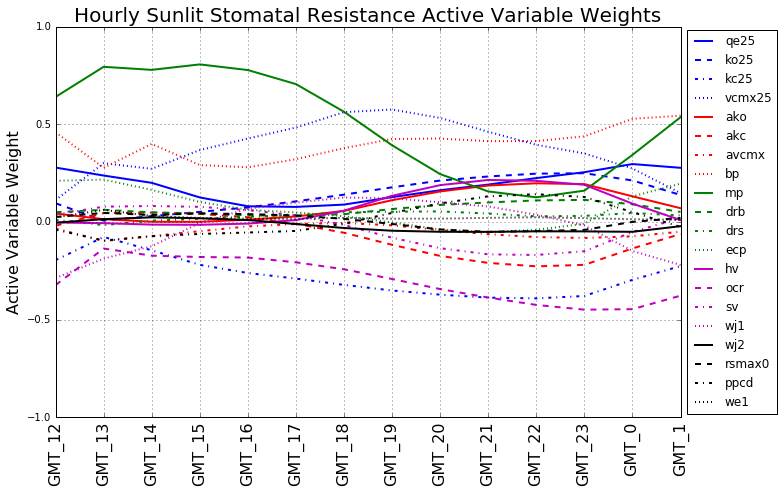

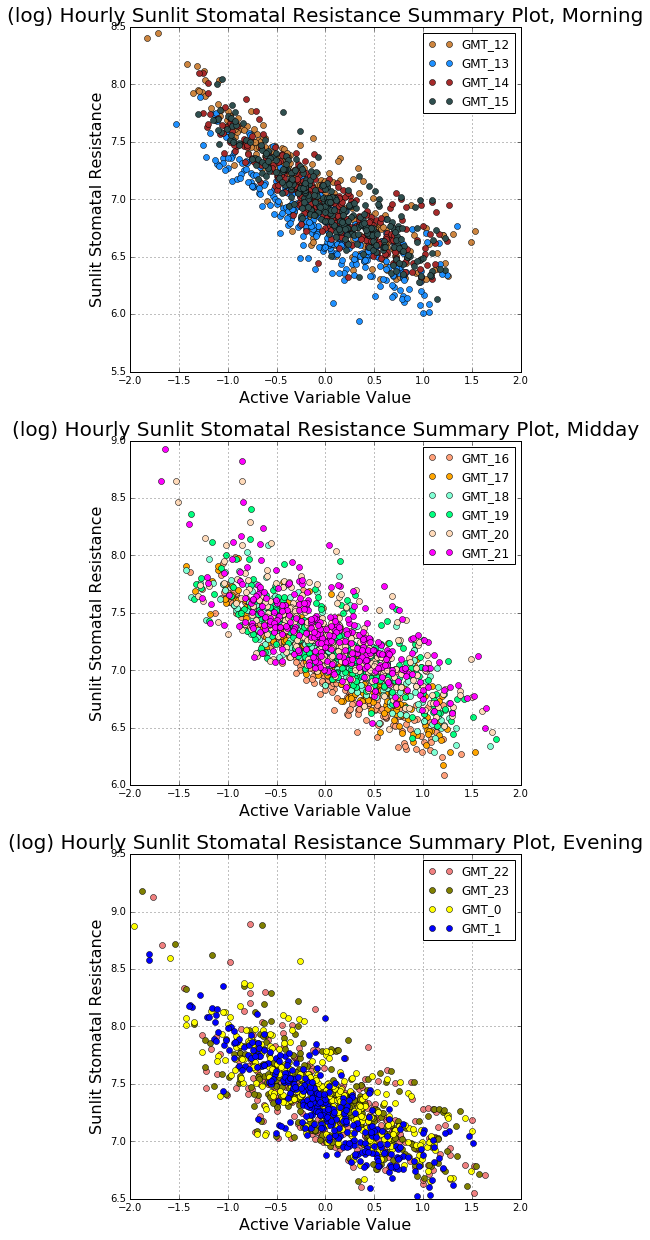

In [8]:
#Make plots for hourly-averaged sunlit stomatal resistance

plt.figure(figsize=(14, 7))
for i in range(res_sun_hourly.shape[1]):
    ss.compute(X=XX, f=res_sun_hourly[:,i][:,None], sstype='OLS')
    plt.plot(range(1, 21), ss.W1, linewidth=0, marker='o', color=colors[i],
             markersize=8, label=hour_labels[i])
plt.xticks(range(1, 21), in_labels, rotation='vertical', fontsize=16)
plt.ylim([-1, 1]); plt.xlim([0, 21]); plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Hourly Sunlit Stomatal Resistance Active Variable Weights', fontsize=20)

res_sun_hourly_weights = np.empty((14, 20))
for i in range(14):
    ss.compute(X=XX, f=res_sun_hourly[:,i][:,None], sstype='OLS')
    res_sun_hourly_weights[i,:] = ss.W1.squeeze()    
plt.figure(figsize=(14,7))
for i in range(20):
    plt.plot(range(0, 14), res_sun_hourly_weights[:,i], color=Colors[i], linestyle=styles[i],
             linewidth=2, label=in_labels[i])
plt.xticks(range(0, 14), hour_labels, rotation='vertical', fontsize=16)
plt.xlim((0, 13))
plt.ylim([-1, 1])
plt.grid(True)
plt.ylabel('Active Variable Weight', fontsize=16)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Hourly Sunlit Stomatal Resistance Active Variable Weights', fontsize=20)

plt.subplots(3, 1, figsize=(7, 7*3))
for j in range(3):
    plt.subplot(3, 1, j+1)
    for k in range(len(indices[j])):
        i = indices[j][k]
        ss.compute(X=XX, f=res_sun_hourly[:,i][:,None], sstype='OLS')
        plt.plot(XX.dot(ss.W1), np.log(res_sun_hourly[:,i]), linewidth=0, marker='o',
                 color=colors[i], markersize=6, label=hour_labels[i])
    plt.grid(True)
    plt.ylabel('Sunlit Stomatal Resistance', fontsize=16)
    plt.xlabel('Active Variable Value', fontsize=16)
    plt.legend(loc='upper right')
    plt.title('(log) Hourly Sunlit Stomatal Resistance Summary Plot, {}'.format(times[j]), fontsize=20)

The hourly data shows many of the same properties as the monthly data. We again see fairly tight trends in the summary plots, important parameters are similar between monthly and hourly cases, and sunlit stomatal resistance shows more hour-to-hour weight variation than shaded resistance and transpiration (though the hourly case shows more weight variation generally compared to the monthly case).

This analysis can provide insight to a modeller about which parameters need to be carefully specified for accurate prediction of these outputs; parameters with high weight affect the output more than the others, so comparatively large uncertainty in them will lead to large uncertainty in output. This exploration also shows that the active subspace method has potential for use in hydrologic models; expanding implementations of these models to include gradients could allow us to build better one-dimensional subspaces or exploit higher-dimensional structure that we can't detect with our gradient-free algorithm.